In [2]:
from dask_image.imread import imread
import dask.array as da
import os
import numpy as np
import joblib
import dask  # Import Dask first
dask.config.set({'dataframe.query-planning': False})  # Disable query-planning

import dask.dataframe as dd  # Now import dask.dataframe
import pandas as pd
import dask.dataframe as dd
from spatialdata import read_zarr

c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
sdata = read_zarr(r"C:\Users\Mattias\Documents\projects\HOGENT\Bach_proef\Bachelor_proef_VIB\Testdata_MACSima\Testdata_CA.zarr")

sdata

SpatialData object, with associated Zarr store: C:\Users\Mattias\Documents\projects\HOGENT\Bach_proef\Bachelor_proef_VIB\Testdata_MACSima\Testdata_CA.zarr
├── Images
│     ├── 'channel_0': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_1': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_2': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_3': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_4': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_5': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_6': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_7': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_8': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_9': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_10': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_11': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_12': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_13': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_14': DataArray[cyx] (1, 4500, 7000)
│     ├── 'channel_

In [4]:
import random as r

image = sdata['channel_22'].data.squeeze()
h, w = image.shape
image_size = 1024

x = r.randint(0, w-image_size)
y = r.randint(0, h-image_size)

print(x, y)

image[y:y+image_size,x:x+image_size]

5893 2398


dask.array<getitem, shape=(1024, 1024), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In [5]:
keys = list(sdata.images.keys())

keys

['channel_0',
 'channel_1',
 'channel_10',
 'channel_100',
 'channel_101',
 'channel_102',
 'channel_103',
 'channel_104',
 'channel_105',
 'channel_106',
 'channel_107',
 'channel_108',
 'channel_109',
 'channel_11',
 'channel_110',
 'channel_111',
 'channel_112',
 'channel_113',
 'channel_114',
 'channel_115',
 'channel_116',
 'channel_117',
 'channel_118',
 'channel_119',
 'channel_12',
 'channel_120',
 'channel_121',
 'channel_122',
 'channel_123',
 'channel_124',
 'channel_125',
 'channel_126',
 'channel_127',
 'channel_128',
 'channel_129',
 'channel_13',
 'channel_130',
 'channel_131',
 'channel_132',
 'channel_133',
 'channel_134',
 'channel_135',
 'channel_136',
 'channel_137',
 'channel_138',
 'channel_139',
 'channel_14',
 'channel_140',
 'channel_141',
 'channel_142',
 'channel_143',
 'channel_144',
 'channel_145',
 'channel_146',
 'channel_147',
 'channel_148',
 'channel_149',
 'channel_15',
 'channel_150',
 'channel_151',
 'channel_152',
 'channel_16',
 'channel_17',
 'ch

In [6]:
IMAGE_SIZE = 256
STRIDE = IMAGE_SIZE - 32

def extract_patches(array:np.ndarray):
    patches = []
    h, w = array.shape

    # Ensure that the image dimensions are divisible by the patch size and stride
    for i in range(0, h - IMAGE_SIZE + 1, STRIDE):
        for j in range(0, w - IMAGE_SIZE + 1, STRIDE):
            img_patch = array[i:i+IMAGE_SIZE, j:j+IMAGE_SIZE]
            patches.append(img_patch)

    return np.array(patches)
    
extract_patches(sdata['channel_0'].data.squeeze()).shape

(589, 256, 256)

In [9]:
import spatialdata

def extract_patches_per_channel(sdata:spatialdata.SpatialData):

    for i in sdata.images.values():
        print(i)


In [3]:
import tensorflow as tf

new_model = tf.keras.models.load_model()

X, Y =  extract_patches_per_channel(sdata)


new_model.predict(X)

TypeError: load_model() missing 1 required positional argument: 'filepath'

In [ ]:
def pad_image_to_patch_size(img, patch_size):
    h, w = img.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    return np.pad(img, ((0, pad_h), (0, pad_w)), mode='reflect')

In [12]:
IMAGE_SIZE = 256
STRIDE = IMAGE_SIZE - 32

from skimage.util import view_as_windows

def extract_patches_skimage(array: np.ndarray):
    window_shape = (IMAGE_SIZE, IMAGE_SIZE)
    step = STRIDE
    patches = view_as_windows(array, window_shape, step=step)
    patches = patches.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
    return patches


out = extract_patches_skimage(sdata['channel_0'].values.squeeze())
shape = extract_patches(sdata['channel_0'].data.squeeze())

In [5]:
import sys
import os
import numpy as np
import logging
import keras

import gc
from tensorflow.keras import backend as K

from spatialdata import SpatialData
from spatialdata import read_zarr
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from skimage.util import view_as_windows

In [7]:
from tensorflow.keras.losses import binary_crossentropy

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def binary_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [ ]:
model = keras.models.load_model(
                r"..\model\pixel_classifier_256.keras",
                custom_objects={'bce_dice_loss': bce_dice_loss, 'binary_iou': binary_iou}
            )

model.state_updates

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                   

In [8]:
IMAGE_SIZE = 256
STRIDE = IMAGE_SIZE - 32

def extract_patches_skimage(array):
    window_shape = (IMAGE_SIZE, IMAGE_SIZE)
    step = STRIDE
    patches = view_as_windows(array, window_shape, step=step)
    patches = patches.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
    
    return patches


def min_max_scaler(X):
    min = np.min(X)
    max = np.max(X)
    return (X-min)/(max-min)

In [9]:
import numpy as np
import tensorflow as tf

def iou_binary(arr1, arr2):
    assert arr1.shape == arr2.shape, "Arrays must have the same shape"
    
    intersection = np.logical_and(arr1, arr2).sum()
    union = np.logical_or(arr1, arr2).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    score = intersection / union if union != 0 else 0
    
    return score

def predict_and_evaluate(model, image_array, label_array):
    """
    Runs model prediction and compares with labels using binary IoU.

    Parameters:
    - model: trained Keras model
    - image_array: NumPy array of shape (N, H, W) or (N, H, W, 1)
    - label_array: NumPy array of shape (N, H, W) or (N, H, W, 1)
    """
    if image_array.ndim == 2:
        image_array = image_array[np.newaxis, ..., np.newaxis]
    elif image_array.ndim == 3:
        # If shape is (batch, height, width), add channel dim
        image_array = image_array[..., np.newaxis]
    
    if label_array.ndim == 2:
        label_array = label_array[np.newaxis, ..., np.newaxis]
    elif label_array.ndim == 3:
        label_array = label_array[..., np.newaxis]

    # Predict
    predictions = model.predict(image_array)

    # Calculate IoU
    iou_values = binary_iou(label_array, predictions)

    # Run the tensor through a session (if using TensorFlow 2.x Eager, just use .numpy())
    iou_numpy = iou_values.numpy()

    # Print results
    for i, iou in enumerate(iou_numpy):
        print(f"Image {i}: IoU = {iou:.4f}")

    return iou_numpy

In [13]:
evals = []

dir = r"E:\data\test"
for i in os.listdir(dir):
    sdata = read_zarr(os.path.join(dir, i))

    keys = list(sdata.images.keys())

    labels_data = sdata['annotations'].values//255

    for i in keys[:1]:

        image_data = sdata[i].values.squeeze()
        image_data = min_max_scaler(image_data)

        data_patches = extract_patches_skimage(image_data)
        
        label_patches = extract_patches_skimage(labels_data)

        if data_patches.shape[0] != label_patches.shape[0]:
            continue

        X = data_patches[..., np.newaxis].astype(np.float16)  # shape: (num_patches, 256, 256, 1)
        Y = label_patches[..., np.newaxis].astype(np.float16)

        evals.append(model.predict(X))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [11]:
evals = []

for i, l in zip(images, labels):
    ious = predict_and_evaluate(model, i, l)
    evals.append(ious)

np.mean(evals)

1/1 [==============================] - 0s 16ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 14ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 19ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 15ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 15ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 14ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 15ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 15ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 15ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 14ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 14ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 14ms/step
Image 0: IoU = 1.0000
1/1 [==============================] - 0s 17ms/step
Image 0: IoU = 1.0000
1/1 [==============================] -

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(images)

from PIL import Image
import numpy as np

img = Image.fromarray(predictions.squeeze(), 'L')
lab = Image.fromarray(labels[0])
img.show()

ValueError: in user code:

    File "c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "max_pooling2d" "                 f"(type MaxPooling2D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node model/max_pooling2d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](model/conv2d_1/Relu)' with input shapes: [32,256,1,32].
    
    Call arguments received by layer "max_pooling2d" "                 f"(type MaxPooling2D):
      • inputs=tf.Tensor(shape=(32, 256, 1, 32), dtype=float32)


In [ ]:
directories = open(r"..\model\files.txt", "r")

directories.read().split("\n")

In [4]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size//1_000_000
list = []
dir = r"E:\data\train"
for arg in os.listdir(dir):
    size = get_size(os.path.join(dir, arg))
    list.append((arg, size))

def myFunc(e):
  return e[1]

list.sort(key=myFunc)

for i in list:
    print(f"{i[0]}: {i[1]}")

2024_09_12_M16_CellineEveraert_12_R01_B01_ROI2.zarr: 3884
2024_09_12_M16_CellineEveraert_12_R01_B01_ROI1.zarr: 3907
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI1.zarr: 5598
Testdata_CA.zarr: 5997
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI5.zarr: 6396
2024_09_20_M17_SPC-035_HelenaAegerter_R01_A01_ROI3.zarr: 6851
2024_03_15_CelineEveraert_3_R01_D01_ROI1.zarr: 7226
Testdata_CE.zarr: 7376
2024_09_12_M16_CellineEveraert_12_R01_B01_ROI3.zarr: 8102
2024_09_12_M16_CellineEveraert_12_R01_B01_ROI4.zarr: 8384
2024_03_15_CelineEveraert_3_R01_B01_ROI1.zarr: 9800
2024_09_20_M17_SPC-035_HelenaAegerter_R01_A01_ROI2.zarr: 10070
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI4.zarr: 12562
2024-09-25_exp38_SPC-036_CelineEveraert 1_R01_B01_ROI2.zarr: 13908
2024_03_15_CelineEveraert_3_2_R01_D01_ROI1.zarr: 16198
2024_03_15_CelineEveraert_3_2_R01_B01_ROI1.zarr: 21604
2024_08_29_M14_CelineEveraert_11_R01_B01_ROI2.zarr: 22461
2024_08_29_

In [63]:
import napari
from scipy.ndimage import label
from scipy.ndimage import binary_erosion

# create the viewer with an image
viewer = napari.Viewer()
dir = r"E:\data\train"
for arg in os.listdir(dir):
    print(arg)
    sdata = read_zarr(os.path.join(dir, arg))

    data = sdata['annotations'].data + 1

    structure = np.ones((3, 3))

    eroded = binary_erosion(data, structure=structure)

    labeled_array, num_features = label(eroded, structure=structure)

    viewer.add_labels(eroded)

napari.run()

2023_11_22_CelineEveraert_R1_B1_ROI1.zarr
2023_11_22_CelineEveraert_R1_D1_ROI1.zarr


c:\Users\Mattias\anaconda3\envs\tf\lib\site-packages\napari\_vispy\layers\scalar_field.py:198: UserWarning: data shape (15411, 36972) exceeds GL_MAX_TEXTURE_SIZE 32768 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


2024-09-25_exp38_SPC-036_CelineEveraert 1_R01_B01_ROI1.zarr
2024-09-25_exp38_SPC-036_CelineEveraert 1_R01_B01_ROI2.zarr
2024_03_15_CelineEveraert_2b_R01_B01_ROI1.zarr
2024_03_15_CelineEveraert_3_2_R01_B01_ROI1.zarr
2024_03_15_CelineEveraert_3_2_R01_D01_ROI1.zarr
2024_03_15_CelineEveraert_3_R01_B01_ROI1.zarr
2024_03_15_CelineEveraert_3_R01_D01_ROI1.zarr
2024_08_29_M14_CelineEveraert_11_R01_B01_ROI1.zarr
2024_08_29_M14_CelineEveraert_11_R01_B01_ROI2.zarr
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI1.zarr
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI2.zarr
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI3.zarr
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI4.zarr
2024_09_06_M15_Annelies_Van Hemelryk_UCSC_Neuroblastoma_2_R01_A01_ROI5.zarr
2024_09_12_M16_CellineEveraert_12_R01_B01_ROI1.zarr
2024_09_12_M16_CellineEveraert_12_R01_B01_ROI2.zarr
2024_09_12_M16_CellineEveraert_12_R01_B01_ROI3.zarr
2024_09

In [5]:
from scipy.ndimage import label
height = []
width = []
for arg in os.listdir(dir):
    sdata = read_zarr(os.path.join(dir, arg))

    data = sdata['annotations'].data + 1


    labeled_array, num_features = label(data)

    for i in range(1, num_features + 1):
        rows, cols = np.where(labeled_array == i)
        min_row, max_row = rows.min(), rows.max()
        min_col, max_col = cols.min(), cols.max()
        
        height.append(max_row - min_row + 1)
        width.append(max_col - min_col + 1)

# Print dimensions of each shape
print(f"- Mean: W={np.mean(width)} H={np.mean(height)}")
print(f"- std: W={np.std(width)} H={np.std(height)}")
print(f"- Max: W={np.max(width)} H={np.max(height)}")
print(f"- Min: W={np.min(width)} H={np.min(height)}")

- Mean: W=2923.427435387674 H=2404.123260437376
- std: W=1046.7861551791439 H=909.9052103186986
- Max: W=24735 H=15387
- Min: W=1631 H=301


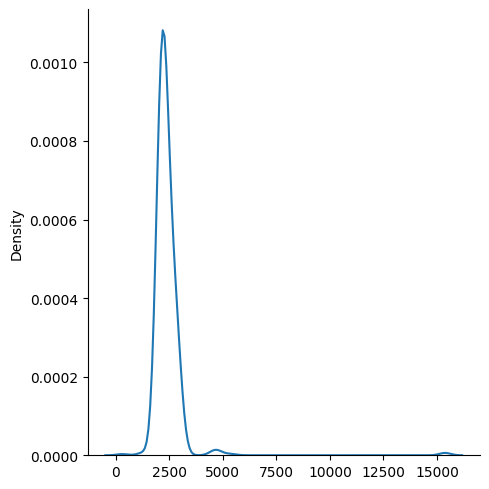

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(height, kind="kde")

plt.show()

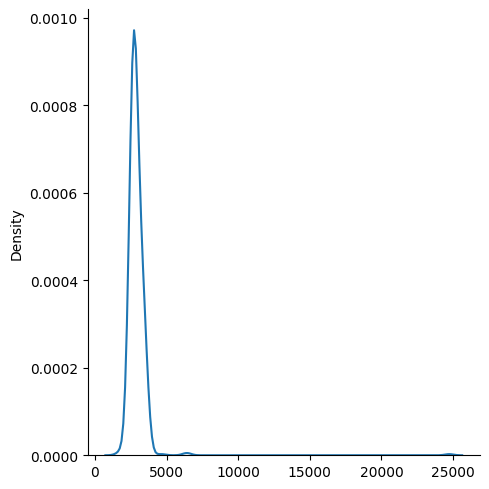

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(width, kind="kde")

plt.show()

In [9]:
def propogation(array, X, Y, W, H, T, prop_list=(0,1,2,3), mirror=False):
    
    height, width = array.shape

    # For set 0
    if 0 in prop_list:
        X1_0 = X
        X2_0 = X1_0+W
        Y1_0 = Y-T-H
        Y2_0 = Y1_0+H

        new_X1_0 = X1_0
        new_Y1_0 = Y1_0

        to_prop = True
        
        if width<=X2_0+W//2:
            X2_0 = width
        
        if 0>=X1_0-W//2:
            new_X1_0 = 0

        if 0>Y1_0-H//2:
            new_Y1_0 = 0
            to_prop = False

        
        array[new_Y1_0:Y2_0,new_X1_0:X2_0] = 0
    
        if to_prop:
            propogation(array, X1_0, Y1_0, W, H, T, prop_list=[0])

    # For set 3
    if 1 in prop_list:
        X1_3 = X
        X2_3 = X1_3+W
        Y1_3 = Y+T+H
        Y2_3 = Y1_3+H

        new_X1_3 = X1_3
        new_Y1_3 = Y1_3

        to_prop = True
        
        if width<=X2_3+W//2:
            X2_3 = width
        
        if 0>=X1_3-W//2:
            new_X1_3 = 0

        if height<=Y2_3+H//2:
            Y2_3 = height
            to_prop = False
            
        array[new_Y1_3:Y2_3,new_X1_3:X2_3] = 0

        if to_prop:
            propogation(array, X1_3, Y1_3, W, H, T, prop_list=[1])

    # For set 1
    if 2 in prop_list:
        X1_1 = X+W+T
        X2_1 = X1_1+W

        if mirror:
            Y1_1 = Y-H//5-T
        else:
            Y1_1 = Y + H//5+T
        Y2_1 = Y1_1+H

        prop_list_1 = [0, 1]
        if width<=X2_1+W//2:
            array[Y1_1:Y2_1,X1_1:width] = 0
        else:
            prop_list_1.append(2)
        
        array[Y1_1:Y2_1,X1_1:X2_1] = 0

        propogation(array, X1_1, Y1_1, W, H, T, prop_list=prop_list_1, mirror=not mirror)

    # For set 5
    if 3 in prop_list:
        X1_5 = X-W-T
        X2_5 = X1_5 + W
        if mirror:
            Y1_5 = Y-H//5+T
        else:
            Y1_5 = Y + H//5+T
        Y2_5 = Y1_5 + H

        prop_list_5 = [0, 1]
        if 0>=X1_5-W//2:
            array[Y1_5:Y2_5,0:X2_5] = 0
        else:
            prop_list_5.append(3)

        array[Y1_5:Y2_5,X1_5:X2_5] = 0


        propogation(array, X1_5, Y1_5, W, H, T, prop_list=prop_list_5, mirror=not mirror)

    return array


def annotation_mask(width, height, W=2550, H=2050, T=500):
    if height<H and width<W:
        return np.zeros((height, width), dtype=int)

    annotations = np.ones((height, width), dtype=int)

    x1 = 3750
    x2 = x1+W
    y1 = 2500
    y2 = y1+H

    if width<W*1.5:
        x1 = 0
        y1+=T
        annotations[y1:y2,x1:width] = 0
        return propogation(annotations, x1, y1, W, H, T, prop_list=(0, 1))
    
    if x2+W//2>=width:
        x2 = width

    if y2+H//2>=height:
        y2 = height

    annotations[y1:y2,x1:x2] = 0

    return propogation(annotations, x1, y1, W, H, T)

In [10]:
sdata = read_zarr(r"e:\data\train\Testdata_CE.zarr")

annotation = sdata['annotations'].values

H, W = annotation.shape

label = annotation_mask(W, H)

In [119]:
import napari

viewer = napari.Viewer()

viewer.add_labels(annotation)
viewer.add_labels(label)

# viewer.theme = 'light'

napari.run()

In [ ]:
import numpy as np

def iou_binary(arr1, arr2):
    assert arr1.shape == arr2.shape, "Arrays must have the same shape"
    
    intersection = np.logical_and(arr1, arr2).sum()
    union = np.logical_or(arr1, arr2).sum()
    
    return intersection / union if union != 0 else 0

In [14]:
dir = r"e:\data\train"

evals = dict()

for arg in os.listdir(dir):
    sdata = read_zarr(os.path.join(dir, arg))

    annotation = sdata['annotations'].values
    H, W = annotation.shape
    label = annotation_mask(W, H, T=475)

    val = iou_binary(annotation, label)

    evals[label.shape] = val

In [22]:
import collections

for i in collections.OrderedDict(sorted(evals.items(), key=lambda x: x[0]*i[1])).items():
    print(i)

((4500, 7000), 0.14853118063564102)
((5274, 6376), 0.6051698756748637)
((5281, 6341), 0.15292658370247064)
((5286, 6346), 0.1341145613504455)
((7791, 9445), 0.6466870650415651)
((7792, 9405), 0.5967272536327978)
((7795, 6383), 0.6386986908686326)
((7796, 6341), 0.04740992895805142)
((10300, 9410), 0.03920429673519039)
((10329, 12509), 0.04028822031866044)
((12768, 3308), 0.03663157894736842)
((12846, 9457), 0.49508079160189084)
((12848, 15549), 0.5233183697063236)
((12853, 15545), 0.5696491802365631)
((15345, 12458), 0.03914112310175851)
((15357, 12502), 0.037679941635296324)
((15364, 15558), 0.4880084043043596)
((15369, 9441), 0.6108793140804943)
((15369, 12521), 0.5695497007951701)
((15387, 24735), 0.5001652361806144)
((15411, 36972), 0.4655052832453524)
((15554, 9617), 0.6039699631287468)
((15554, 12676), 0.566508079472944)
((17927, 30837), 0.5513967200528818)
